In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from config import N_HAND_LANDMARKS, N_POSE_LANDMARKS, UPPER_BODY_CONNECTIONS
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

## 0. Preparing testing example

In [2]:
import cv2
import keypoint_extract as md

source_path = "../notebooks/dataset/videos/D0014.mp4"
image_dir = "../notebooks/dataset/visualization/images"

# Capture video frames as images
cap = cv2.VideoCapture(source_path)
os.makedirs(image_dir, exist_ok=True)
print("Capture video frames processing...")
frame_id = 0
while True:
    ret, frame = cap.read()
    if not ret:
        frame_id += 1
        break
    save_path = os.path.join(image_dir, f"frame_{frame_id}.jpg")
    cv2.imwrite(save_path, frame)
    print(f"Saved: {save_path}")
    frame_id += 1
cap.release()
print("Done saving frames")

Capture video frames processing...
Saved: ../notebooks/dataset/visualization/images/frame_0.jpg
Saved: ../notebooks/dataset/visualization/images/frame_1.jpg
Saved: ../notebooks/dataset/visualization/images/frame_2.jpg
Saved: ../notebooks/dataset/visualization/images/frame_3.jpg
Saved: ../notebooks/dataset/visualization/images/frame_4.jpg
Saved: ../notebooks/dataset/visualization/images/frame_5.jpg
Saved: ../notebooks/dataset/visualization/images/frame_6.jpg
Saved: ../notebooks/dataset/visualization/images/frame_7.jpg
Saved: ../notebooks/dataset/visualization/images/frame_8.jpg
Saved: ../notebooks/dataset/visualization/images/frame_9.jpg
Saved: ../notebooks/dataset/visualization/images/frame_10.jpg
Saved: ../notebooks/dataset/visualization/images/frame_11.jpg
Saved: ../notebooks/dataset/visualization/images/frame_12.jpg
Saved: ../notebooks/dataset/visualization/images/frame_13.jpg
Saved: ../notebooks/dataset/visualization/images/frame_14.jpg
Saved: ../notebooks/dataset/visualization/ima

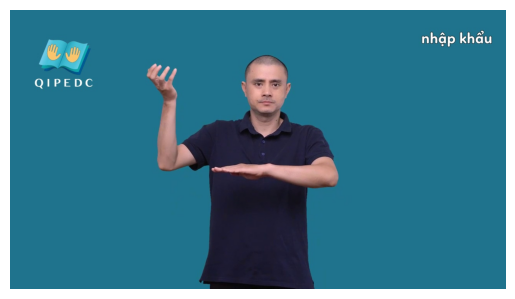

In [3]:
image = cv2.imread("../notebooks/dataset/visualization/images/frame_57.jpg")

def display_image(image, axis=False, grid=False, alpha=1):
    """Plot image with matplotlib and cv2."""
    
    plt.figure()
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), alpha=alpha)
    if not axis:
        plt.axis('off')
    if grid:
        plt.grid()
    plt.show()
    
display_image(image)

In [4]:
def add_keypoints_to_image(image, list_landmarks, color=(0, 255, 0)):
    """Plot image with keypoints."""
    
    image_height, image_width, _ = image.shape
    for (x, y, _) in list_landmarks:
        if x != 0 and y != 0:
            px = int(x * image_width)
            py = int(y * image_height)
            cv2.circle(image, (px, py), 4, color, -1)

red, blue, green = (0, 0, 255), (255, 0, 0), (0, 255, 0)

## 1. Extract keypoints

### 1.1 For image (one frame)

In [5]:
# def extract_keypoints(results, visibility_thres=0.5):
#     """Extract all keypoints from one video frame."""
    
#     # Upper pose
#     pose_landmarks = []
#     if results.pose_landmarks:
#         landmarks = results.pose_landmarks.landmark
#         for idx, i in enumerate(UPPER_BODY_CONNECTIONS):
#             if i < len(landmarks):
#                 res = landmarks[i]
#                 if res.visibility < visibility_thres:
#                     pose_landmarks.append([0.0, 0.0, 0.0])
#                 else:
#                     pose_landmarks.append([res.x, res.y, res.z])
#     else:
#         pose_landmarks = [[0.0, 0.0, 0.0]] * N_POSE_LANDMARKS
    
#     # Left hand
#     if results.left_hand_landmarks:
#         left_hand_landmarks = [[lm.x, lm.y, lm.z] for lm in results.left_hand_landmarks.landmark]
#     else:
#         left_hand_landmarks = [[0.0, 0.0, 0.0]] * N_HAND_LANDMARKS

#     # Right hand
#     if results.right_hand_landmarks:
#         right_hand_landmarks = [[lm.x, lm.y, lm.z] for lm in results.right_hand_landmarks.landmark]
#     else:
#         right_hand_landmarks = [[0.0, 0.0, 0.0]] * N_HAND_LANDMARKS
    
#     return pose_landmarks, left_hand_landmarks, right_hand_landmarks

In [6]:
import keypoint_extract as md
import mediapipe as mp

mp_holistic = mp.solutions.holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5)

I0000 00:00:1761542888.323699  230265 gl_context.cc:369] GL version: 2.1 (2.1 INTEL-20.7.3), renderer: Intel(R) Iris(TM) Plus Graphics 640
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [7]:
_, results = md.mediapipe_detection(image, mp_holistic)
print(results)
pose_landmarks, left_hand_landmarks, right_hand_landmarks = md.extract_keypoints(results)

W0000 00:00:1761542889.461604  230605 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1761542889.574199  230607 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1761542889.596128  230604 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1761542889.596469  230606 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1761542889.652271  230606 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1761542889.658170  230604 inference_feedback_manager.cc:114] Feedback manager 

<class 'mediapipe.python.solution_base.SolutionOutputs'>


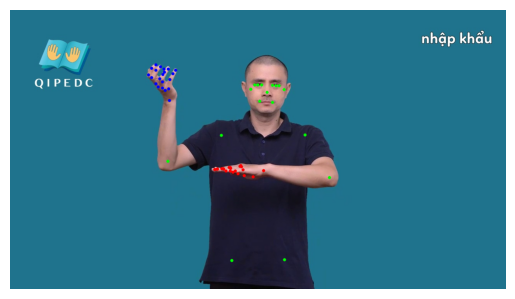

In [8]:
add_keypoints_to_image(image, pose_landmarks, color=green)
add_keypoints_to_image(image, left_hand_landmarks, color=red)
add_keypoints_to_image(image, right_hand_landmarks, color=blue)
display_image(image)

### 1.2 For video

In [9]:
def get_list_frame(source_path):
    """Extract keypoints sequences from one video."""
    
    frames_keypoints = []
    cap = cv2.VideoCapture(source_path)
    while cap.isOpened():
        # read video frame
        success, image = cap.read()

        # skip empty frames
        if not success:
            break
        
        # MediaPipe Holistic processing
        _, results = md.mediapipe_detection(image, mp_holistic)
        pose_landmarks, left_hand_landmarks, right_hand_landmarks = md.extract_keypoints(results)
        
        frames_keypoints.append([left_hand_landmarks, right_hand_landmarks, pose_landmarks])
    cap.release()
    return frames_keypoints
    
def concate_array(left_hand_landmarks, right_hand_landmarks, pose_landmarks):
    """ """
    
    a1 = np.array(left_hand_landmarks).reshape(-1)
    a2 = np.array(right_hand_landmarks).reshape(-1)
    a3 = np.array(pose_landmarks).reshape(-1)
    result = np.concatenate((a1, a2, a3), axis=None)
    return result

def check_zeros(list_landmarks):
    data = np.array(list_landmarks)
    if np.all(data == 0):
        return True
    return False

In [10]:
try:
    list_fr = get_list_frame(source_path)
    X = []
    list_idx = []
    for i in range(len(list_fr)):
        if not check_zeros(list_fr[i][0]) or not check_zeros(list_fr[i][1]):
            X.append(concate_array(list_fr[i][0], list_fr[i][1], list_fr[i][2]))
            list_idx.append(i)
    
    # filtering frame
    X_new = np.array(X)
    K = 20
    kmeans = KMeans(n_clusters=K, random_state=42)
    kmeans.fit(X_new)
    cluster_centers = kmeans.cluster_centers_
    distances = cdist(X_new, cluster_centers, 'euclidean')  # d[i][j]: distance from frame i to cluster center j
    nearest_indies = np.argmin(distances, axis=0)                 
    index = np.sort(nearest_indies)
    print(index)
    data = []
    for i in index:
        data.append(list_fr[list_idx[i]])
    data_save = np.asarray(data, dtype="object")

except Exception as e:
    print(f"error write: {e}")

[ 0  2  5  7  9 11 12 14 16 29 35 39 55 62 64 65 66 67 68 73]


Frame 0 (Frame 1 in video):


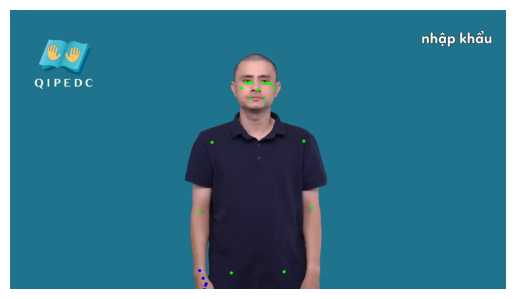

Frame 1 (Frame 34 in video):


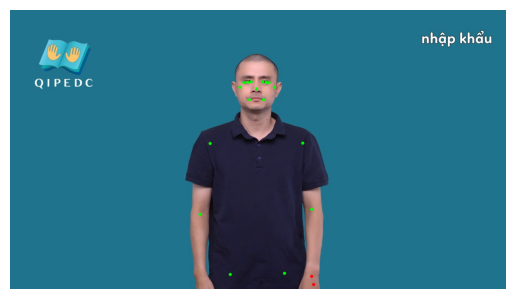

Frame 2 (Frame 38 in video):


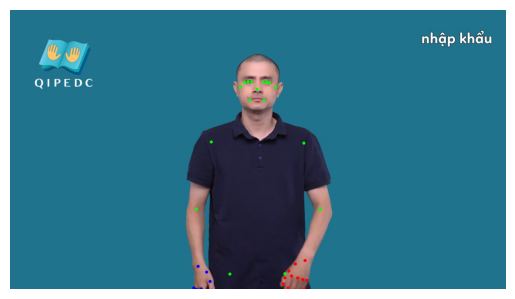

Frame 3 (Frame 40 in video):


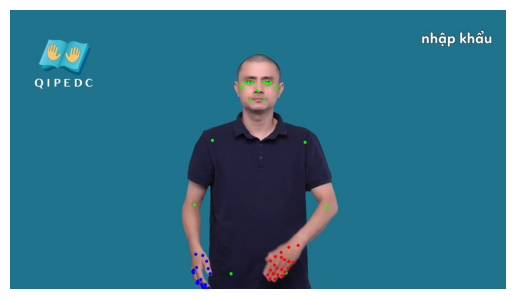

Frame 4 (Frame 42 in video):


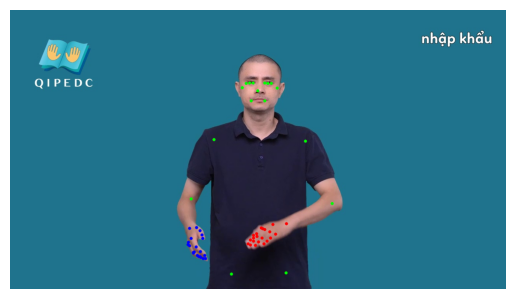

Frame 5 (Frame 44 in video):


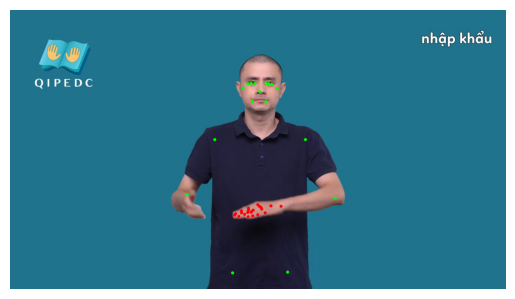

Frame 6 (Frame 45 in video):


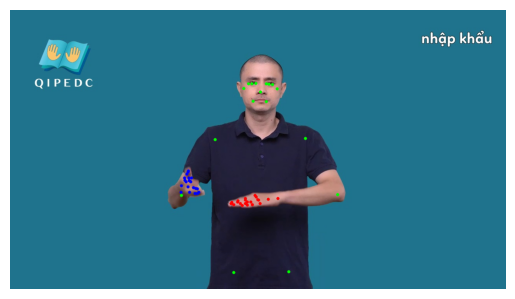

Frame 7 (Frame 47 in video):


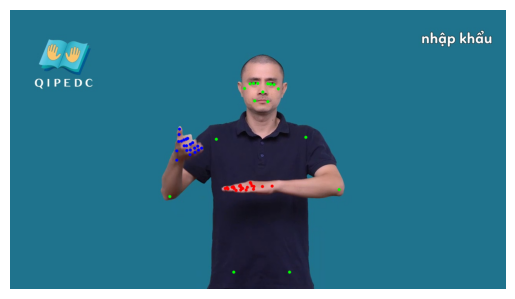

Frame 8 (Frame 49 in video):


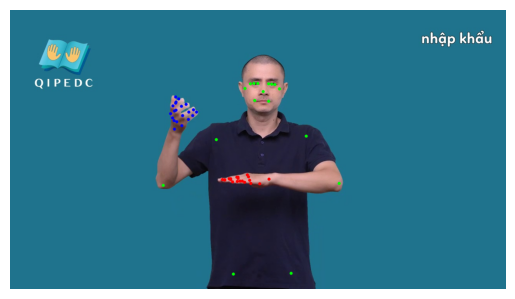

Frame 9 (Frame 62 in video):


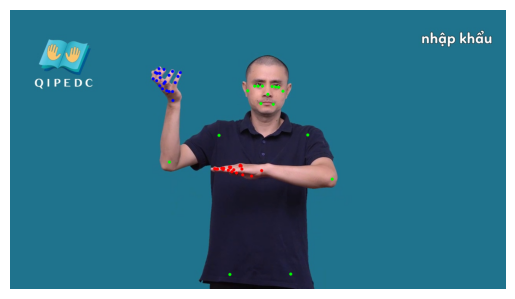

Frame 10 (Frame 68 in video):


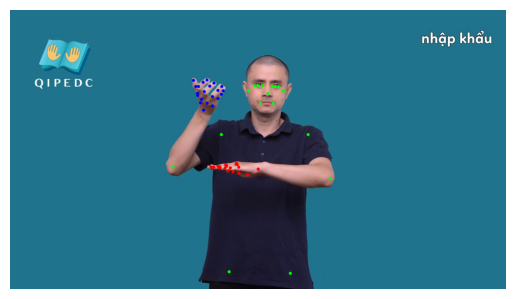

Frame 11 (Frame 72 in video):


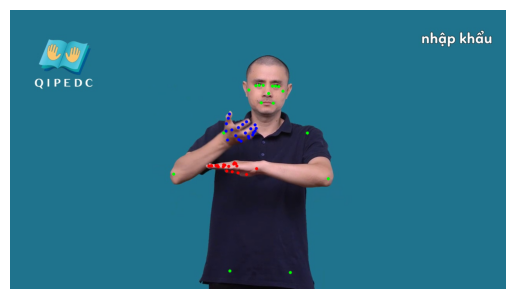

Frame 12 (Frame 88 in video):


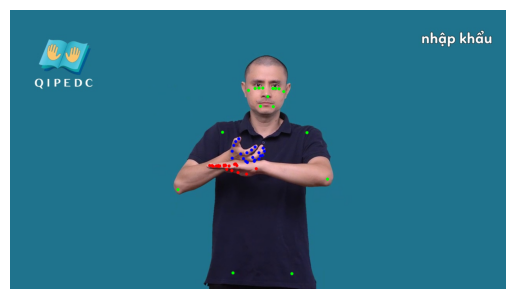

Frame 13 (Frame 95 in video):


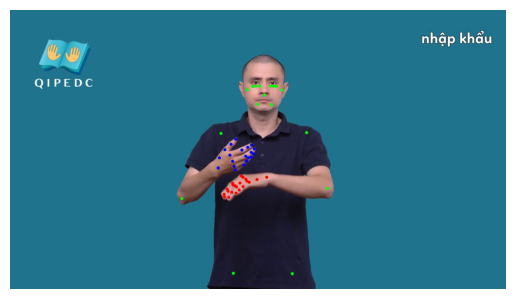

Frame 14 (Frame 97 in video):


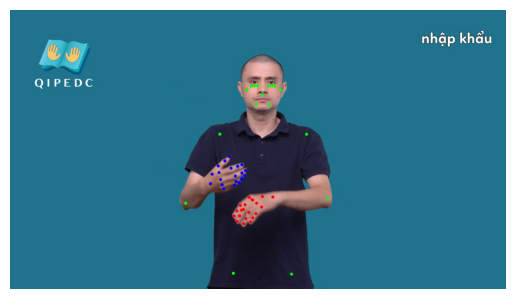

Frame 15 (Frame 98 in video):


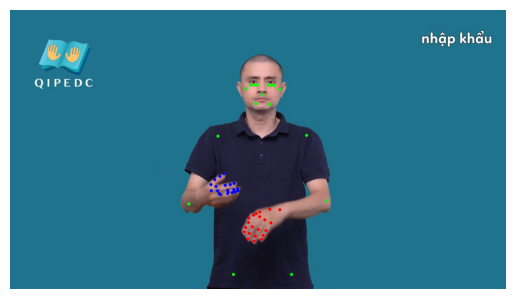

Frame 16 (Frame 99 in video):


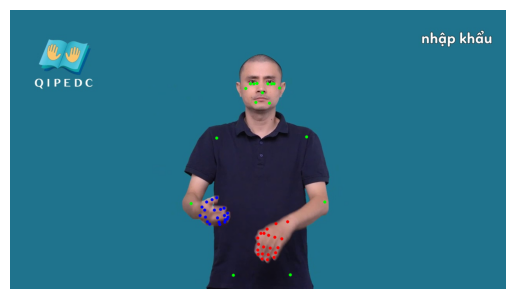

Frame 17 (Frame 100 in video):


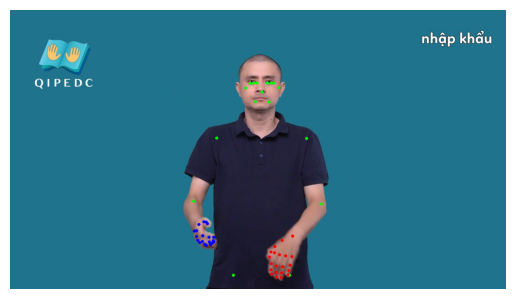

Frame 18 (Frame 101 in video):


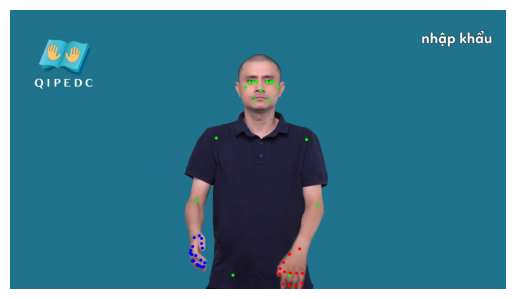

Frame 19 (Frame 106 in video):


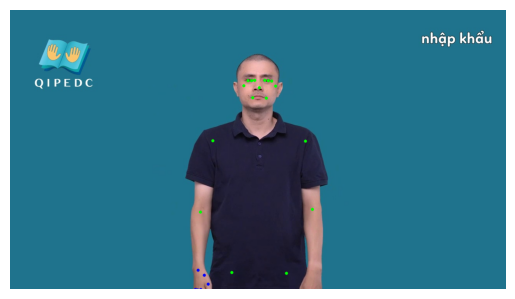

In [11]:
for i, (lh, rh, pose) in enumerate(data_save):
    idx = index[i]
    print(f"Frame {i} (Frame {list_idx[idx]} in video):")
    image = cv2.imread(f"../notebooks/dataset/visualization/images/frame_{list_idx[idx]}.jpg")

    add_keypoints_to_image(image, pose, color=green)
    add_keypoints_to_image(image, lh, color=red)
    add_keypoints_to_image(image, rh, color=blue)

    display_image(image)


In [12]:
np.save(os.path.join("../notebooks/dataset/visualization/", "0.npy"), data_save)

In [13]:
data_save.shape

(20, 3)

In [14]:
frame_0 = data_save[0]
print(f"Left-hand landmarks: \n{frame_0[0]}\n")
print(f"Right-hand landmarks: \n{frame_0[1]}\n")
print(f"Pose landmarks: \n{frame_0[2]}\n")

Left-hand landmarks: 
[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]

Right-hand landmarks: 
[[0.39153775572776794, 1.0017980337142944, 2.0740063177981938e-07], [0.3944830596446991, 0.9870507717132568, -0.029892293736338615], [0.3957335352897644, 0.9806971549987793, -0.05270175263285637], [0.38910382986068726, 0.9621056318283081, -0.07102058827877045], [0.3824978768825531, 0.9335428476333618, -0.0901484340429306], [0.39408108592033386, 1.0436925888061523, -0.05063609033823013], [0.39549264311790466, 1.0700762271881104, -0.06730026006698608], [0.39596837759017944, 1.087463140487671, -0.07788684219121933], [0.39579886198043823, 1.100448727607727, -0.08508890867233276], [0.3924389481

## 2. Generate new data from 1

In [15]:
import create_point as aug

source_sample = np.load("../notebooks/dataset/visualization/0.npy", allow_pickle=True)

path_to_save = "../notebooks/dataset/visualization/augmentation"
os.makedirs(path_to_save, exist_ok=True)
n_samples = 10
n_name = 0
if n_name < n_samples:
    try:
        for index in range(n_name, n_samples):
            new_file = path_to_save + "/" + str(index) + ".npy"
            result = []
            frame_0 = aug.create_frame_0(source_sample)
            # print(frame_0)
            result.append(frame_0)
            for t in range(1, 20):
                frame_i = aug.create_frame_t(t, source_sample, frame_0)
                result.append(frame_i)
            data_save = np.asarray(result, dtype="object")
            np.save(new_file, data_save)
    except Exception as e:
        print(f"error when generate augmented data: {e}.")
    

../notebooks/dataset/visualization/augmentation/0.npy
../notebooks/dataset/visualization/augmentation/1.npy
../notebooks/dataset/visualization/augmentation/2.npy
../notebooks/dataset/visualization/augmentation/3.npy
../notebooks/dataset/visualization/augmentation/4.npy
../notebooks/dataset/visualization/augmentation/5.npy
../notebooks/dataset/visualization/augmentation/6.npy
../notebooks/dataset/visualization/augmentation/7.npy
../notebooks/dataset/visualization/augmentation/8.npy
../notebooks/dataset/visualization/augmentation/9.npy


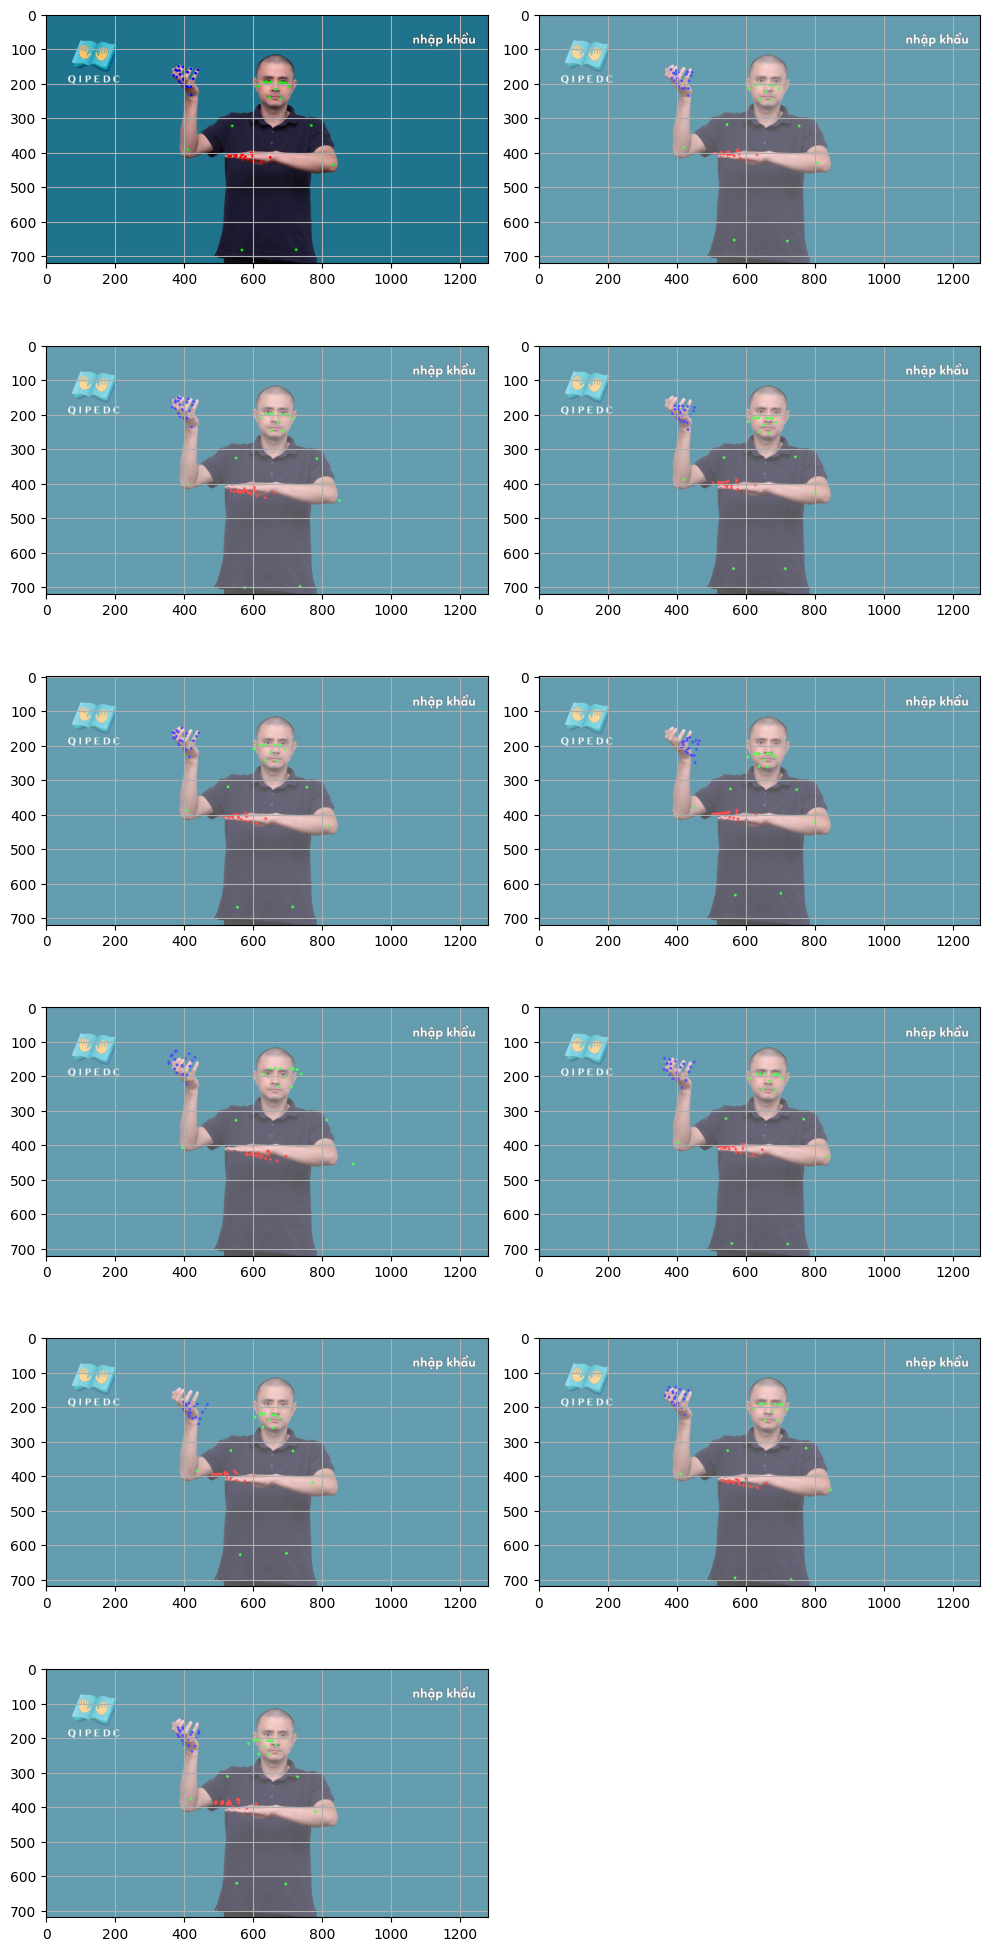

In [16]:
rows, cols = 6, 2 # grid
f_idx = 62
kps_idx = 9
plt.figure(figsize=(10, 20))
keypoints_dir = "../notebooks/dataset/visualization"
sub_dir = "augmentation"

for i in range(0, 11):
    plt.subplot(rows, cols, i+1)
    image = cv2.imread(f"../notebooks/dataset/visualization/images/frame_{f_idx}.jpg")
    
    if i == 0: # origin keypoints
        path_file = keypoints_dir + "/0.npy"
        alpha=1
    else:
        path_file = os.path.join(keypoints_dir, sub_dir) + "/" + str(i-1) + ".npy"
        print(path_file)
        alpha=0.7
    
    data = np.load(path_file, allow_pickle=True)
    # lh, rh, pose = data[0]
    lh, rh, pose = data[kps_idx]
    add_keypoints_to_image(image, pose, color=green)
    add_keypoints_to_image(image, lh, color=red)
    add_keypoints_to_image(image, rh, color=blue)
    # display_image(image, axis=True, grid=True, alpha=alpha)  
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), alpha=alpha)
    plt.axis()
    plt.grid()
        
plt.tight_layout()
plt.show()